# PROJECT:  Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets




In [1]:
# Change here using YOUR first and last names
fn1 = "daniel"
ln1 = "wamo"
fn2 = "samuel"
ln2 = "guilhem-ducleon"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_wamo_daniel_and_guilhem-ducleon_samuel.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

Let $F : (w,b) \rightarrow \frac{1}{2}w^{\top}w$.

$\frac{\partial^2 F}{\partial w^2} = I$, $\frac{\partial^2 F}{\partial b^2} = 0$, $\frac{\partial^2 F}{\partial b \partial w} = 0$, $\frac{\partial^2 F}{\partial w \partial b} = 0$

$\nabla^2 F(w, B)$ is positive semidefinite (diagonal matrix with coefficients equal to 0 or 1, thus symmetric and all eigenvalues are positive) so F is convex and the problem $(\mathcal{P})$ is convex.

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

Let $\mu = (\mu_1, ..., \mu_n)$

$\mathcal{L}(w, b, \mu) = \frac{1}{2} w^Tw - \sum_{i=1}^n \mu_i (y_i(w^Tx_i + b) - 1)$ with $\forall i$, $\mu_i \ge 0$

We have at the extremum (saddle point):

$\nabla_w \mathcal{L}(w) = w - \sum_{i=1}^{n} \mu_i y_i x_i = 0$ (stationarity of KKT conditions)

$\nabla_b \mathcal{L}(b) = - \sum_{i=1}^n \mu_i y_i = 0$ (stationarity of KKT conditions)

$\forall i$, $\mu_i(1 - y_i(w^Tx_i + b)) = 0$ (complementarity of KKT conditions)

with $\forall i$, $\mu_i \ge 0$

Finally: let $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$

The first equation is equivalent to: $w = G^{\top} \mu$

The second equation is equivalent to: $y^{\top}\mu = 0$

And the last constraint is equivalent to: $- \mu \leq 0$

The dual problem consists in maximizing the Lagragian:

$\mathcal{L}(w, b, \mu) = \frac{1}{2} w^Tw - \sum_{i=1}^n \mu_i (y_i(w^Tx_i + b) - 1)
= \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top}x_j + \sum_i \mu_i - \sum_{i,j}\mu_i \mu_j y_i y_j x_i^{\top}x_j = \mu^{\top} 1_n  - \frac{1}{2} \mu^T G G^{\top} \mu$ 

Maximizing the lagragian is equivalent to minimizing its opposite.

Thus we have the following dual problem:

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}1_n
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

By definition we have: $f(x)=\mathrm{sign}(w^{\top}x + b)$

In the previous question we showed that the KKT conditions imply: $w - \sum_{i=1}^{n} \mu_i y_i x_i = 0$

Therefore: $y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace$

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [3]:
from svm_project_utils import plot_dataset, datasets

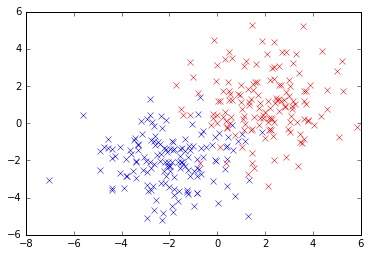

In [4]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [5]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [6]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

Number of support vectors: 3


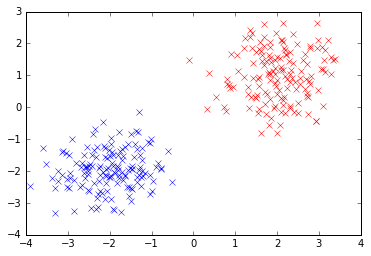

In [7]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    n = y.shape[0]
    H = np.outer(y,y) * K
    e = np.ones(n)
    A = y
    b = 0.0
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [8]:
# TODO
w = mu_support.dot(np.multiply(X[idx_support], y[idx_support].reshape((-1,1)))).reshape((-1,1))

- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

In [9]:
# TODO

def compute_b(K, y, mu_support, idx_support):
    # TODO
    if len(idx_support) < 1:
        return -1
    
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    w = mu_support.dot(np.multiply(X[idx_support], y[idx_support].reshape((-1,1)))).reshape((-1,1))
    b = (1/y_support[0]) - w.T.dot(X[idx_support][0])
    return b

b = compute_b(K, y, mu_support, idx_support)

print("Value of b: %F" % b[0])

Value of b: 0.646021


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [10]:
def check_constraints(epsilon = 1e-5):
    n = y.shape[0]

    satisfied = True
    
    wrong_i = []

    for i in range(n):
        greater_than_1 = y[i]*(w.T.dot(X[i,:]) + b) + epsilon

        if greater_than_1 < 1:
            satisfied = False
            wrong_i.append(i)

    if satisfied:
        print("The constraints of the primal problem are satisfied for epsilon = %F" % epsilon)
    else:
        print("The constraints are not satisfied for the following i: %s" % str(wrong_i))
        
check_constraints(1e-5)

The constraints of the primal problem are satisfied for epsilon = 0.000010


Check your code by running the following cell:

In [11]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

In [12]:
def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)
    
    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

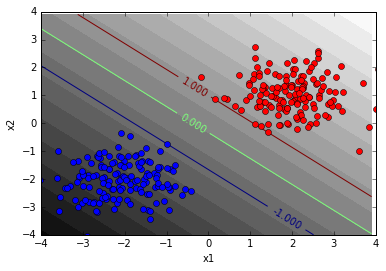

In [13]:
plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

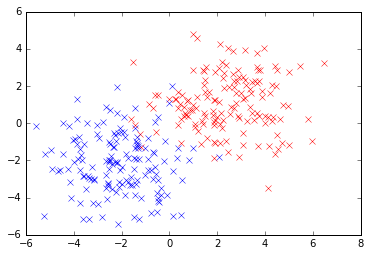

In [14]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [15]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

- Q8: Check that contraints of the problem are now violated.

In [16]:
check_constraints(epsilon=1e-5)

The constraints are not satisfied for the following i: [5, 21, 23, 24, 25, 26, 33, 35, 44, 45, 53, 67, 68, 77, 83, 87, 89, 90, 91, 94, 95, 97, 99, 100, 106, 113, 119, 135, 137, 144, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

Let $F(w, b, \xi) = \frac{1}{2}w^T w + C \sum_i \xi_i$ be the function to minimize.

$\frac{\partial^2}{\partial w^2}F(w, b, \xi) = I$

All the other second order partial derivates equal zero.

The Hessian matrix is positive semidefinite (diagonal matrix with coefficients equal to 1 or 0).

The problem $(P_s)$ is thus convex.

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

Let $\mu = (\mu_1, ..., \mu_n)$

$\mathcal{L}(w, b, \mu, \alpha) = \frac{1}{2} w^Tw + C \sum_i \xi_i - \sum_{i=1}^n \mu_i (y_i(w^Tx_i + b) - 1 + \xi_i) - \sum_i \alpha_i \xi_i$ with $\forall i$, $\mu_i \ge 0$

The KKT conditions are the following:

$\nabla_w \mathcal{L}(w) = w - \sum_{i=1}^{n} \mu_i y_i x_i = 0$

$\nabla_b \mathcal{L}(b) = - \sum_{i=1}^n \mu_i y_i = 0$

$\forall i$, $\mu_i(1 - \xi_i - y_i(w^Tx_i + b)) = 0$

$\forall i$, $\mu_i \ge 0$ $(*)$

$\forall i$, $y_i(x_i^T w + b) - 1 + \xi_i \le 0$

$\forall i$, $\alpha_i \ge 0$ $(**)$

$\forall i$, $\alpha_i \xi_i = 0$

$\forall i$, $\alpha_i + \mu_i = C$ $(***)$

$\forall i$, $\xi_i \ge 0$


Finally: let $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$

We deduce from the first equation that: $w = G^{\top} \mu$

The second equation is equivalent to: $y^{\top}\mu = 0$

Using $(*)$: $\mu \ge 0$

Using $(**)$ and $(***)$: $\mu \le C$

The dual problem consists in maximizing the Lagragian:

$\mathcal{L}(w, b, \mu, \alpha) = \frac{1}{2} w^Tw + C \sum_i \xi_i - \sum_{i=1}^n \mu_i (y_i(w^Tx_i + b) - 1 + \xi_i) - \sum_i \alpha_i \xi_i
= \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top}x_j + \sum_i \xi_i (C - \mu_i -\alpha_i) + \sum_i \mu_i - \sum_{i,j}\mu_i \mu_j y_i y_j x_i^{\top}x_j = \mu^{\top} 1_n  - \frac{1}{2} \mu^T G G^{\top} \mu$ 

Maximizing the lagragian is equivalent to minimizing its opposite.


We have the following dual problem:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}1_n
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- Q10: Modify your code from Q4 to handle the non-separable case.

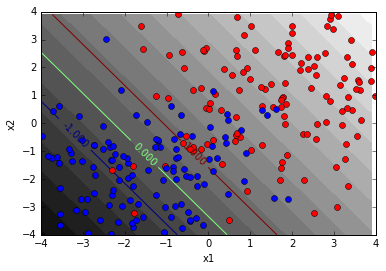

Number of support vectors for C = 100: 72


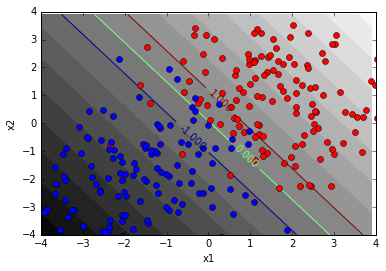

Number of support vectors for C = 10000: 175


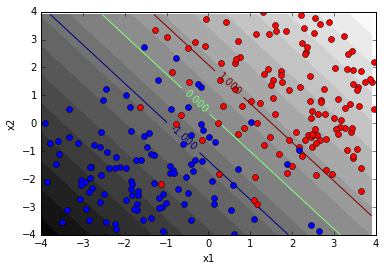

Number of support vectors for C = 1000000: 300


In [17]:
# TODO

for C in [1e2,1e4,1e6]:

    X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

    K = kernel(X, X)
    mu_support, idx_support = svm_solver(K, y, C=C)
    b = compute_b(K, y, mu_support, idx_support)

    plot_classif(X, y, mu_support, idx_support, b)
    plt.show()
    
    print("Number of support vectors for C = %d: %d" % (C, len(idx_support)))

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

The higher C the higher the number of support vectors.

Indeed increasing C increases the bias and avoids overfitting.

The more support vectors the more examples do not satisfy the constraints. On the other hand, the less support vectors the larger the overfit (i.e. the more examples satisfy the constraints and thus the more examples from the training set are well classified).

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

We replace the dot product between $x_i$ and $x_j$ by $K(x_i, x_j)$.

We have: $f(x) = sign(\sum_{i=1}^n \mu_i y_i K(x_i, x) + b)$

We will use the clowns dataset to evaluate this:

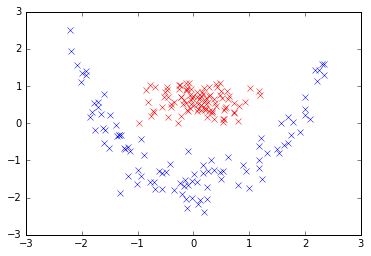

In [18]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [19]:
# TODO

from scipy import linalg
import math

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = math.exp(- gamma * np.linalg.norm(X1[i] - X2[j]))  # CHANGE THIS
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

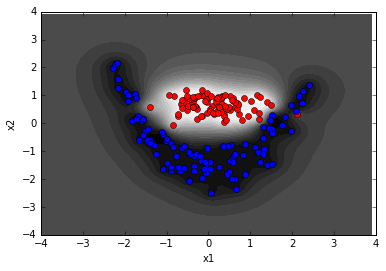

In [20]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

Let $\mu = (\mu_1, ..., \mu_n)$

$\mathcal{L}(w, \mu, \alpha) = \frac{1}{2} w^Tw + C \sum_i \xi_i - \sum_{i=1}^n \mu_i (y_i w^Tx_i - 1 + \xi_i) - \sum_i \alpha_i \xi_i$ with $\forall i$, $\mu_i \ge 0$

The KKT conditions are the following:

$\nabla_w \mathcal{L}(w) = w - \sum_{i=1}^{n} \mu_i y_i x_i = 0$

$\forall i$, $\mu_i(1 - \xi_i - y_iw^Tx_i) = 0$

$\forall i$, $\mu_i \ge 0$ $(*)$

$\forall i$, $y_i x_i^T w - 1 + \xi_i \le 0$

$\forall i$, $\alpha_i \ge 0$ $(**)$

$\forall i$, $\alpha_i \xi_i = 0$

$\forall i$, $\alpha_i + \mu_i = C$ $(***)$

$\forall i$, $\xi_i \ge 0$


Finally: let $G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}$

We deduce from the first equation that: $w = G^{\top} \mu$

Using $(*)$: $\mu \ge 0$

Using $(**)$ and $(***)$: $\mu \le C$

The dual problem consists in maximizing the Lagragian:

$\mathcal{L}(w, \mu, \alpha) = \frac{1}{2} w^Tw + C \sum_i \xi_i - \sum_{i=1}^n \mu_i (y_i w^Tx_i - 1 + \xi_i) - \sum_i \alpha_i \xi_i
= \frac{1}{2} \sum_{i,j} \mu_i \mu_j y_i y_j x_i^{\top}x_j + \sum_i \xi_i (C - \mu_i -\alpha_i) + \sum_i \mu_i - \sum_{i,j}\mu_i \mu_j y_i y_j x_i^{\top}x_j = \mu^{\top} 1_n  - \frac{1}{2} \mu^T G G^{\top} \mu$ 

Maximizing the lagragian is equivalent to minimizing its opposite.

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}1_n
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

Let's define f and g such that:

$f(\mu) = \frac{1}{2} \mu^{\top}GG^{\top}\mu - \mu^{\top}1_n$

$g(\mu) = \sum_{i=1}^n 1_{[0,C]}(\mu_i)$ where $1_{[0,C]}(x)$ equal 0 if x belongs to $[0,C]$, $+\inf$ otherwise.

$\nabla f(\mu) = GG^{\top}\mu$ which is a L-Lipschitz function where L is the norm of $GG^{\top}$.

Therefore f is a smooth function.

g is not smooth and is separable.

The proximal of g is the projection on $[0, C]^n$.

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

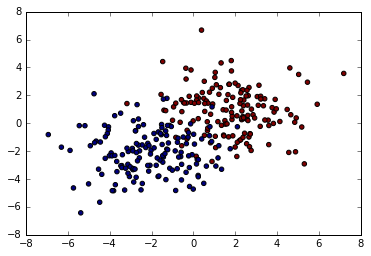

In [21]:
C = 1

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

X = np.concatenate((X, np.ones((len(X), 1))), axis=1)

n = X.shape[0]

K = kernel(X, X)

H = np.outer(y,y) * K

In [22]:
from scipy.optimize import fmin_l_bfgs_b
import random

def f(mu):
    ret = 0.5 * mu.T.dot(H.dot(mu)) - mu.sum()
    return ret

def grad_f(mu):
    return H.dot(mu) - np.ones(mu.shape)

def lip_grad_f():
    """Lipschitz for gradient of f"""  
    L = np.linalg.norm(H)
    
    return L

def g(mu, s):
    if (mu < 0).any() or (mu > C).any():
        return np.inf
    else:
        return 0
    
def prox_g(mu, s, t=1.):
    ret = np.minimum(C, np.maximum(mu, 0))
    return ret
    

def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=200, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape
    
    print(step)

    # objective history
    objectives = []
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    
    for k in range(n_iter + 1):
        x = prox_g(x - step * grad_f(x) , s, step)
        
        obj = f(x) + g(x, s)
        
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    return x, objectives

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=200, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = X.shape
    # objective history
    objectives = []
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))
    for k in range(n_iter + 1):
        x_new = prox_g(z - step * grad_f(z), s, step)
        
        t_new = (1 + math.sqrt(1 + 4 * pow(t,2)))/2
        z = x_new + ((t - 1)/t_new) * (x_new - x)
        
        t = t_new
        x = x_new

        obj = f(x) + g(x, s)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    return x, np.array(objectives)

def prox_g_i(mu, s, t=1.):
    ret = min(C, max(0, mu))
    return ret

def lipschitz_i(i):
    return np.linalg.norm(H[i][:])

def grad_f_i(mu, i):
    return H[i][:].dot(mu) - 1

def coordinate_descent(x0, f, grad_f_i, g, prox_g_i, s=0., n_iter=200, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = X.shape

    # objective history
    objectives = []
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)

    if verbose:
        print("Lauching Coordinate Descent solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj"]]))

    
    for k in range(n_iter + 1):

        x_new = x.copy()
        
        i = random.randint(0, n_features - 1)
        
        L_i = lipschitz_i(i)
        gamma_i = 1./L_i
        
        x_new[i] = prox_g_i(x[i] - gamma_i*grad_f_i(x, i), s, gamma_i)

        x = x_new
        
        obj = f(x) + g(x, s)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    return x, objectives

def inspector(f, n_iter, verbose=True):
    """A closure called to update metrics after each iteration."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(xk):
        obj = f(xk)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    return inspector_cl


def svm_solver(K, y, algorithm="ista", C=np.inf):
    step = 1/lip_grad_f()    
    mu_0 = np.zeros(n)
    
    if algorithm == "fista":
        mu, _ = fista(mu_0, f, grad_f, g, prox_g, step)
    elif algorithm == "cd":
        mu, _ = coordinate_descent(mu_0, f, grad_f_i, g, prox_g_i)
    elif algorithm == "l-bfgs-b":
        bounds = [(0, C)] * mu_0.shape[0]
        n_iter = 200
        callback = inspector(f, n_iter)
        mu, _, _ = fmin_l_bfgs_b(f, mu_0, grad_f, bounds=bounds, maxiter=n_iter, callback=callback)
    else:
        mu, _ = ista(mu_0, f, grad_f, g, prox_g, step)
        
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support


def svm_predict(X, mu_support, idx_support):
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]
    
    X_test = np.concatenate((X_test, np.ones((len(X_test), 1))), axis=1)
    
    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    
    decision = G.dot(mu_support * y[idx_support])
    
    y_pred = np.sign(decision)
    
    # Affichage des lignes de niveau de la fonction de decision
    X = X[:,0:2]
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    
    return y_pred


SVM solver using ISTA
0.000347798740431
Lauching ISTA solver...
   it    |   obj   
       0 | -7.18e-02
      10 | -3.57e-01
      20 | -5.93e-01
      30 | -8.16e-01
      40 | -1.03e+00
      50 | -1.25e+00
      60 | -1.46e+00
      70 | -1.67e+00
      80 | -1.88e+00
      90 | -2.09e+00
     100 | -2.30e+00
     110 | -2.51e+00
     120 | -2.71e+00
     130 | -2.92e+00
     140 | -3.13e+00
     150 | -3.34e+00
     160 | -3.54e+00
     170 | -3.75e+00
     180 | -3.96e+00
     190 | -4.17e+00
     200 | -4.37e+00


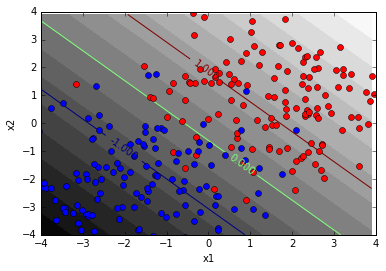

In [23]:
print("SVM solver using ISTA")
mu_support, idx_support = svm_solver(K, y, algorithm="ista", C=C)

y_pred = svm_predict(X, mu_support, idx_support)
plt.show()

SVM solver using FISTA
Lauching FISTA solver...
   it    |   obj   
       0 | -7.18e-02
      10 | -6.43e-01
      20 | -1.68e+00
      30 | -3.22e+00
      40 | -5.27e+00
      50 | -7.84e+00
      60 | -1.09e+01
      70 | -1.45e+01
      80 | -1.87e+01
      90 | -2.33e+01
     100 | -2.85e+01
     110 | -3.32e+01
     120 | -3.76e+01
     130 | -4.05e+01
     140 | -4.28e+01
     150 | -4.44e+01
     160 | -4.53e+01
     170 | -4.61e+01
     180 | -4.66e+01
     190 | -4.71e+01
     200 | -4.74e+01


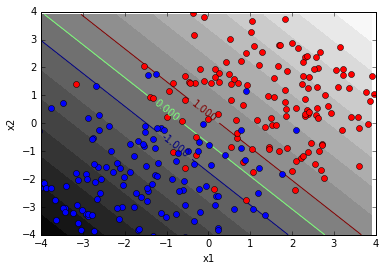

In [24]:
print("SVM solver using FISTA")
mu_support, idx_support = svm_solver(K, y, algorithm="fista", C=C)

y_pred = svm_predict(X, mu_support, idx_support)
plt.show()

SVM solver using coordinate descent
Lauching Coordinate Descent solver...
   it    |   obj   
       0 | -5.66e-03
      10 | -3.85e-02
      20 | -4.82e-02
      30 | -5.19e-02
      40 | -5.56e-02
      50 | -5.83e-02
      60 | -5.98e-02
      70 | -6.04e-02
      80 | -6.16e-02
      90 | -6.28e-02
     100 | -6.36e-02
     110 | -6.41e-02
     120 | -6.49e-02
     130 | -6.56e-02
     140 | -6.62e-02
     150 | -6.71e-02
     160 | -6.78e-02
     170 | -6.83e-02
     180 | -6.88e-02
     190 | -6.94e-02
     200 | -6.98e-02


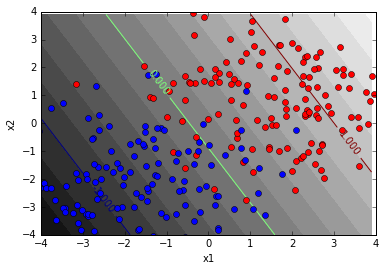

In [25]:
print("SVM solver using coordinate descent")
mu_support, idx_support = svm_solver(K, y, algorithm="cd", C=C)

y_pred = svm_predict(X, mu_support, idx_support)
plt.show()

SVM solver using L-BFGS-B
   it    |   obj   
       0 | -8.37e-02
      40 | -4.73e+01
      80 | -4.81e+01
     120 | -4.82e+01
     160 | -4.82e+01
     200 | -4.82e+01


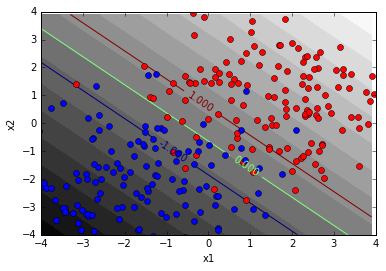

In [26]:
print("SVM solver using L-BFGS-B")
mu_support, idx_support = svm_solver(K, y, algorithm="l-bfgs-b", C=C)

y_pred = svm_predict(X, mu_support, idx_support)
plt.show()

We see that L-BFGS-B and FISTA converge both towards the same minimum.

The convergence of L-BFGS-B is much faster that FISTA.

ISTA is longer to converge than FISTA: we set the same number of iterations and it has not converged totally yet even if it seems to converge towards the same minimum as well. This is explained because the optimal rate of convergence for FISTA is $O(\frac{1}{k^2})$ where k is the number of iterations whereas it is only $O(\frac{1}{k})$ for ISTA.
    
Proximal coordiante descent seemed to converge towards a different minimum.

We can notice that L-BFGS-B is not a proximal method: we had to remove the non-smooth part, g, from the objective function. And instead mention in the argument bounds that all coordinates of the solution has to be between 0 and C.
